In [36]:
# Main
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm

import sys
sys.path.append("../scripts")

In [37]:
def flatten(x):
    return [z for y in x for z in y ]

In [38]:
def plot_grid(df, n_cols, figsize):
    n_rows = int(np.ceil(len(df.columns)/n_cols))
    df.plot(subplots=True, layout=(n_rows, n_cols), figsize=figsize)

In [39]:
def plot_fcst(fcst, train=None, test=None):
    ax = fcst.yhat.plot()
    lower = fcst.yhat_lower.interpolate()
    upper = fcst.yhat_upper.interpolate()
    plt.fill_between(fcst.index, y1=lower, y2=upper, alpha=0.3)
    if train is not None:
        train.plot(style="k.")
    if test is not None:
        test.plot(style="r.")

In [40]:
def get_forecastables(df, T=0.5):
    amount_info = df.notna().sum() / len(df)
    forecastable = (amount_info > T)
    return df.loc[:, forecastable].copy()

In [41]:
def get_amount_info(df):
    amount_info = df.notna().sum() / len(df)
    return amount_info

In [42]:
def fourier(steps, seasonality, n_terms=10):
    coeff_list = []
    t = np.arange(0, steps)
    for period in seasonality:
        coeff_M = np.zeros((steps, 2*n_terms))
        for k in range(n_terms):
            coeff_M[:, 2*k] = np.sin(2*np.pi*(k+1)*t/period)
            coeff_M[:, 2*k+1] = np.cos(2*np.pi*(k+1)*t/period)
        coeff_list.append(coeff_M)
    coeff = np.concatenate(coeff_list, axis=1)
    return coeff

In [43]:
plt.rcParams["figure.figsize"] = (14,4)

In [44]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [45]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


# Forecast por producto

In [46]:
u_producto = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns="producto", 
    aggfunc="sum").asfreq("D")

In [47]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


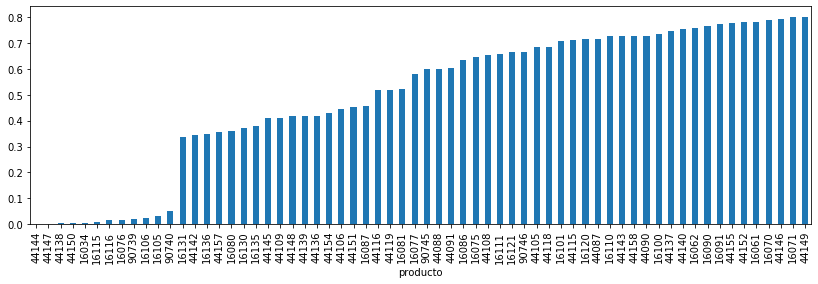

In [48]:
amount_info = get_amount_info(u_producto)
amount_info.sort_values().plot(kind="bar")

In [49]:
u_producto_forecastable = get_forecastables(u_producto, T=0.5)

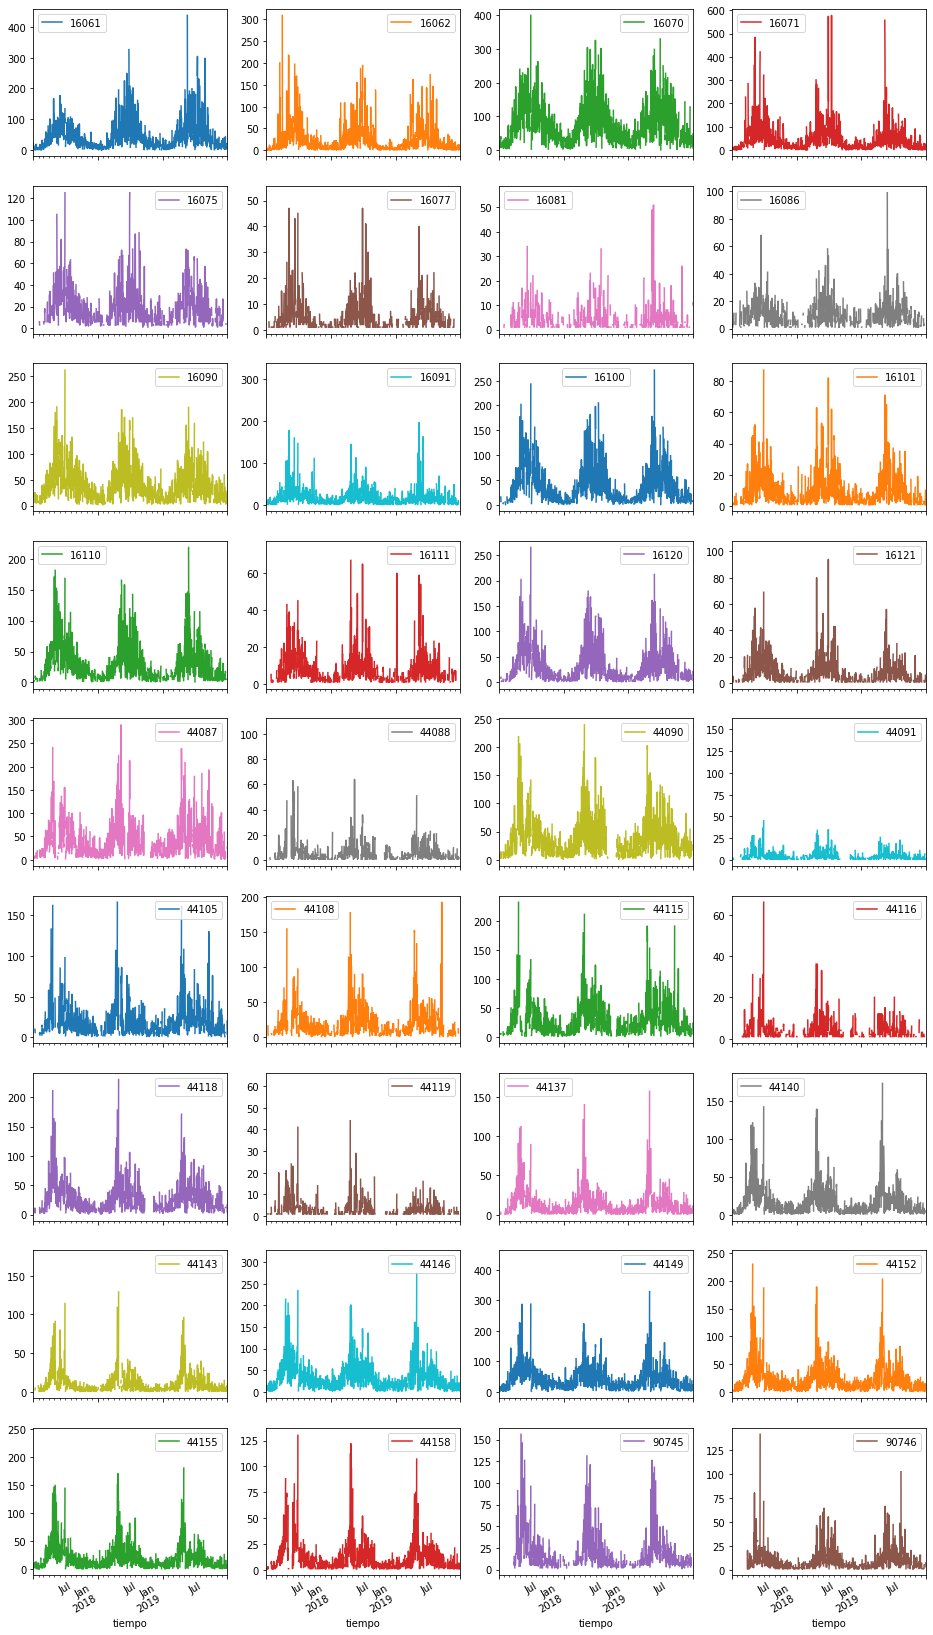

In [50]:
plot_grid(u_producto_forecastable, n_cols=4, figsize=(16, 32))

In [51]:
train, test = u_producto_forecastable[:"2018-12-31"].copy(), u_producto_forecastable["2019-01-01":].copy()

In [52]:
idx = pd.date_range('01-01-2017', '2018-12-31')
train = train.reindex(index=idx)

In [53]:
train.head()

producto,16061,16062,16070,16071,16075,16077,16081,16086,16090,16091,...,44137,44140,44143,44146,44149,44152,44155,44158,90745,90746
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,7.0,1.0,25.0,11.0,3.0,NaN,1.0,NaN,17.0,6.0,...,1.0,1.0,1.0,8.0,14.0,NaN,1.0,NaN,NaN,NaN
2017-01-03,21.0,NaN,27.0,2.0,NaN,NaN,NaN,4.0,21.0,1.0,...,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,8.0,4.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,4.0,2.0,NaN,1.0,1.0,NaN,NaN
2017-01-05,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,5.0,5.0,...,2.0,3.0,3.0,15.0,16.0,NaN,10.0,1.0,NaN,NaN


In [54]:
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from progress_bar import ProgressBar

class ARIMAForecaster:
    def __init__(
        self,
        use_boxcox=True,
        n_fourier_terms=10,
        seasonality=[365.25],
        interval_width=0.8):
    
        self.models = dict()
        self.fcst = dict()
        self.lmbda_boxcox = dict()
        self.use_boxcox = use_boxcox
        self.n_fourier_terms = n_fourier_terms
        self.seasonality = seasonality
        self.interval_width = interval_width
        

    def fit(self, train_df):
        self.ds = pd.Series(train_df.index)
        print("Fitting...")
        progress_bar = ProgressBar(len(train_df.columns))
        
        for item in train_df.columns:
            target = train_df[item].interpolate().bfill()
            if self.use_boxcox:
                idx = target.index
                target, self.lmbda_boxcox[item] = boxcox(target)
                target = pd.Series(target, index=idx)
            target.index.name = "ds"
            target.name = "y"     
            self.models[item] = pm.auto_arima(
                target,
                seasonal=False,
                exogenous=fourier(
                    len(target), 
                    seasonality=self.seasonality, 
                    n_terms=self.n_fourier_terms), 
                method="bfgs",
                suppress_warnings=True)
            progress_bar.update()
        progress_bar.finish()
        return self.models
            
    def predict(self, steps=365):
        print("Forecasting...")
        progress_bar = ProgressBar(len(self.models.items()))
        for item, model in self.models.items():
            pred = model.predict(
                exogenous=fourier(
                    steps, 
                    seasonality=self.seasonality, 
                    n_terms=self.n_fourier_terms),
                n_periods=steps, 
                return_conf_int=True,
                alpha=(1.0 - self.interval_width))
            fcst = pd.DataFrame()
            fcst["yhat_lower"] = pred[1][:,0]
            fcst["yhat"] = pred[0]
            fcst["yhat_upper"] = pred[1][:,1]
            self.fcst[item] = fcst
            if self.use_boxcox:
                self.fcst[item] = inv_boxcox(
                    self.fcst[item], 
                    self.lmbda_boxcox[item])
            progress_bar.update()
        progress_bar.finish()
        return pd.concat(self.fcst, axis=1)

In [55]:
train_df = train.iloc[:, 0:1].copy()

In [56]:
model_arima = ARIMAForecaster(n_fourier_terms=10)

In [57]:
model_arima.fit(train_df)

Fitting...


1 of 1|###################################################################|100%


{16061: ARIMA(maxiter=50, method='bfgs', order=(0, 0, 0), out_of_sample_size=0,
       scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
       start_params=None, suppress_warnings=True, trend=None,
       with_intercept=True)}

In [58]:
fcst = model_arima.predict()

Forecasting...


1 of 1|###################################################################|100%


In [59]:
fcst

16061                     
    yhat_lower      yhat yhat_upper
0     2.886348  8.844467  22.272293
1     2.883019  8.836211  22.254834
2     2.882260  8.834330  22.250857
3     2.882092  8.833912  22.249972
4     2.880542  8.830068  22.241843
..         ...       ...        ...
360   3.018748  9.171578  22.962346
361   2.972498  9.057568  22.722206
362   2.937775  8.971793  22.541278
363   2.913159  8.910890  22.412679
364   2.897076  8.871056  22.328506

[365 rows x 3 columns]

In [72]:
y = test[16061].reset_index(drop=True)

In [73]:
error = fcst[16061].yhat - y

In [78]:
error.abs().mean()

26.661981930359378

In [30]:
fcst.index = test.index

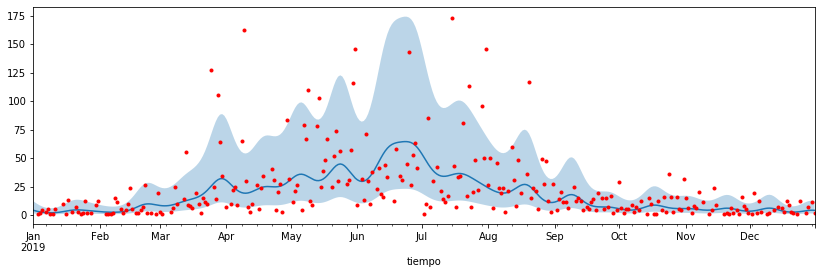

In [35]:
item_id = 16062
plot_fcst(fcst[item_id], test=test[item_id])

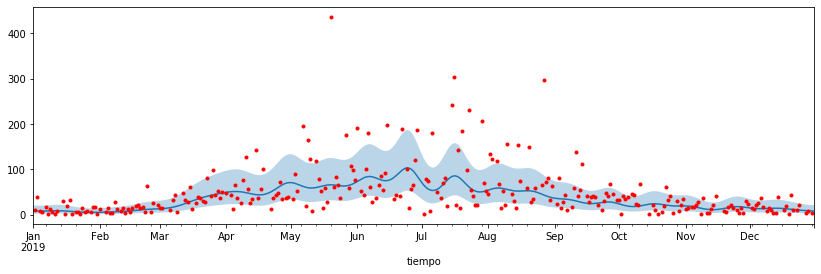

In [88]:
plot_fcst(fcst[16061], test=test[16061])

In [89]:
rolling_mean = train.rolling(window=7, min_periods=1).mean()

In [101]:
error = rolling_mean.tail(365).reset_index(drop=True) - test.reset_index(drop=True)

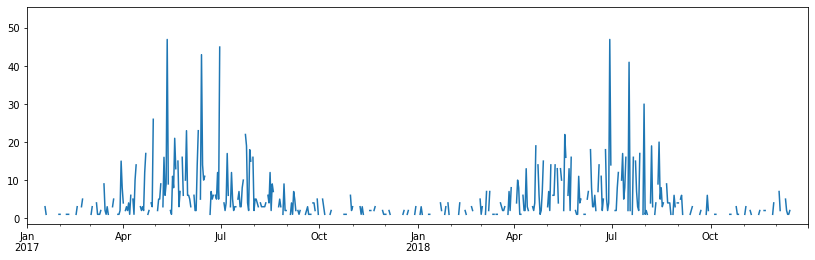

In [107]:
train[16077].plot()

In [105]:
error.abs().mean()

producto
16061    28.049006
16062    17.920357
16070    36.404953
16071    32.538605
16075    10.943463
16077     3.337063
16081     4.456397
16086     6.270833
16090    19.583333
16091    13.358092
16100    22.014366
16101     6.914956
16110    16.471605
16111     5.883193
16120    19.222646
16121     6.095643
44087    27.804626
44088     4.748442
44090    22.319210
44091     3.885910
44105    13.845128
44108    13.608441
44115    18.653910
44116     3.853652
44118    15.591529
44119     2.436111
44137     7.691131
44140     9.537440
44143     6.785440
44146    16.718594
44149    21.506419
44152    12.252069
44155    10.619788
44158     6.635556
90745     9.883406
90746     6.723244
dtype: float64

In [96]:
error = rolling_mean[16061].tail(365).reset_index(drop=True) - test[16061].reset_index(drop=True)

In [97]:
error.abs().mean()

28.049005847953207

In [95]:
rolling_mean[16061].tail(365).reset_index(drop=True)

0      11.25
1      11.50
2       9.75
3      11.00
4       7.60
       ...  
360     9.75
361     8.00
362     7.75
363     7.75
364     7.75
Name: 16061, Length: 365, dtype: float64

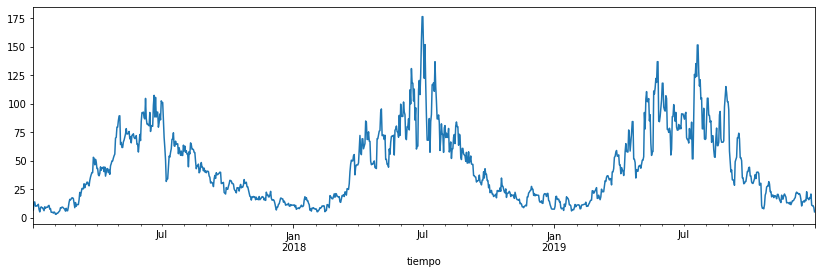

In [87]:
rolling_mean[16061].plot()

In [329]:
item_id = 44149

In [330]:
y_train = train[item_id]
y_test = test[item_id]

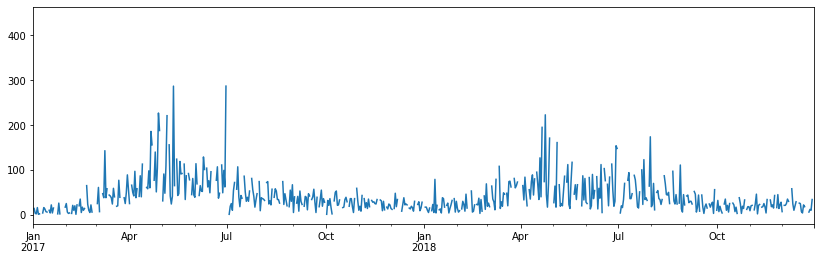

In [331]:
y_train.plot();

In [332]:
idx = y_train.index
y_train_boxcox, lmbda = boxcox(y_train.interpolate().bfill())
y_train_boxcox = pd.Series(target, index=idx)

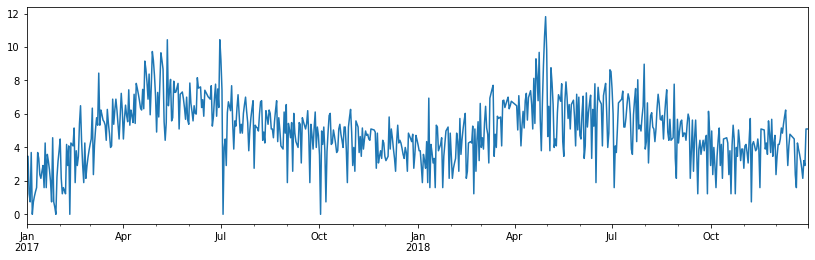

In [333]:
y_train_boxcox.plot()

In [355]:
model_arima = pm.auto_arima(
    y_train_boxcox, 
    exogenous=fourier(2*365, seasonality=[365.25], n_terms=5), 
    seasonal=False,
    maxiter=100,
    method="bfgs",
    suppress_warnings=True)

In [372]:
pred = model_arima.predict(
    n_periods=len(y_test), 
    exogenous=fourier(365, seasonality=[365.25], n_terms=5),
    return_conf_int=True)

In [408]:
fcst_boxcox = pd.DataFrame()

In [409]:
fcst_boxcox["yhat"] = pred[0]

In [410]:
fcst_boxcox["yhat_lower"] = pred[1][:,0]
fcst_boxcox["yhat_upper"] = pred[1][:,1]

In [411]:
fcst_boxcox.index = test.index

In [412]:
fcst = inv_boxcox(fcst_boxcox, lmbda)

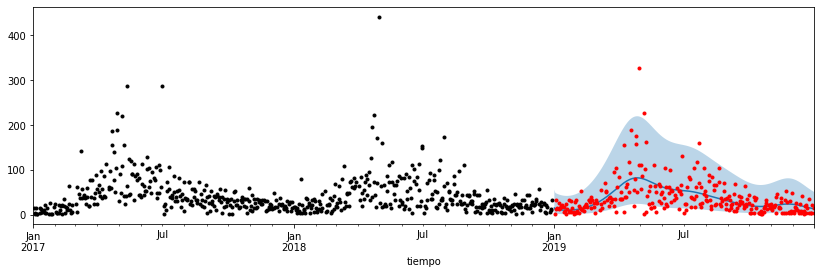

In [417]:
plot_fcst(fcst, train=y_train, test=y_test)

AttributeError: 'Line2D' object has no property 'style'

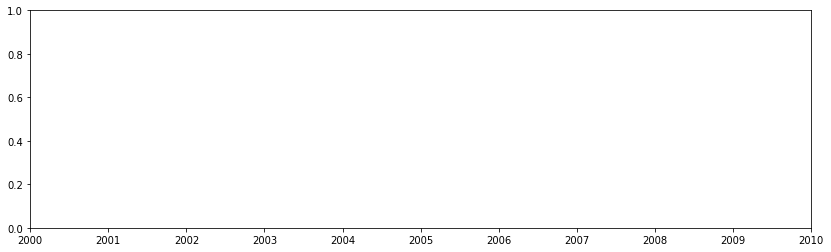

In [416]:
plt.plot(y_train, style="k.")
plt.plot(y_test, style="r.")

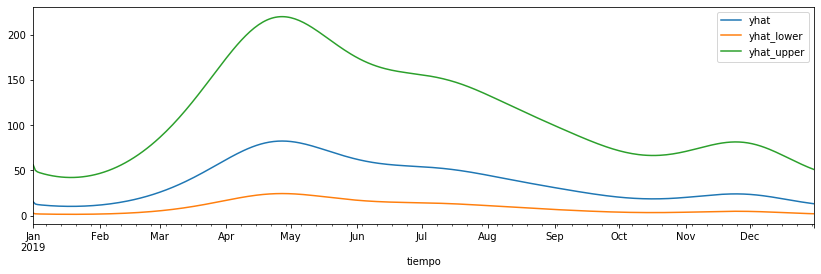

In [413]:
fcst.plot()

In [403]:
fcst.plot()
y_test.plot(style="r.")
y_train.plot(style="k.")

TypeError: no numeric data to plot

In [ ]:
fcst.plo

In [362]:
fcst.reindex(index=pd.date_range(start="2019-01-01", end="2019-12-31", freq="D"))

2019-01-01   NaN
2019-01-02   NaN
2019-01-03   NaN
2019-01-04   NaN
2019-01-05   NaN
              ..
2019-12-27   NaN
2019-12-28   NaN
2019-12-29   NaN
2019-12-30   NaN
2019-12-31   NaN
Freq: D, Length: 365, dtype: float64

In [240]:
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

2017-01-01     NaN
2017-01-02    14.0
2017-01-03     3.0
2017-01-04     2.0
2017-01-05    16.0
              ... 
2018-12-27    12.0
2018-12-28    10.0
2018-12-29    34.0
2018-12-30     NaN
2018-12-31     NaN
Freq: D, Name: 44149, Length: 730, dtype: float64

In [243]:

fcoeff = fourier(2*365, seasonality=[365.25], n_terms=5)

In [247]:
train_df = y_train.reset_index()

In [249]:
fcoeff

array([[ 0.        ,  1.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.01720158,  0.99985204,  0.03439806, ...,  0.99763355,
         0.0859061 ,  0.99630324],
       [ 0.03439806,  0.99940821,  0.06875541, ...,  0.99054539,
         0.17117706,  0.98524028],
       ...,
       [-0.06017211,  0.99818802, -0.12012617, ...,  0.97113941,
        -0.29651591,  0.95502791],
       [-0.0429928 ,  0.99907538, -0.0859061 , ...,  0.98524028,
        -0.21337703,  0.97696993],
       [-0.02580077,  0.9996671 , -0.05158437, ...,  0.99467811,
        -0.12866054,  0.99168869]])

In [251]:
fcoeff = pd.DataFrame(fcoeff)

In [253]:
train_df = train_df.join(fcoeff)

In [257]:
train_df = train_df.rename(columns={"index":"ds", 44149:"y"})

In [263]:
train_df = train_df.dropna()

In [268]:
"0 1 2 3 4 5 6 7 8 9".split()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [269]:
train_df.columns = ["ds", "y", '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [270]:
train_df

,ds,y,0,1,2,3,4,5,6,7,8,9
1,2017-01-02,14.0,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.085906,0.996303
2,2017-01-03,3.0,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545,0.171177,0.985240
3,2017-01-04,2.0,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769,0.255182,0.966893
4,2017-01-05,16.0,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360,0.337301,0.941397
5,2017-01-06,1.0,0.085906,0.996303,0.171177,0.985240,0.255182,0.966893,0.337301,0.941397,0.416926,0.908940
...,...,...,...,...,...,...,...,...,...,...,...,...
720,2018-12-22,18.0,-0.179645,0.983732,-0.353445,0.935455,-0.515744,0.856742,-0.661263,0.750154,-0.785267,0.619157
724,2018-12-26,6.0,-0.111583,0.993755,-0.221772,0.975099,-0.329192,0.944263,-0.432499,0.901634,-0.530405,0.847744
725,2018-12-27,12.0,-0.094472,0.995527,-0.188099,0.982150,-0.280044,0.959987,-0.369484,0.929237,-0.455618,0.890175
726,2018-12-28,10.0,-0.077334,0.997005,-0.154204,0.988039,-0.230151,0.973155,-0.304719,0.952442,-0.377462,0.926025


In [272]:
m = Prophet(seasonality_mode="additive", 
            yearly_seasonality=False, 
            weekly_seasonality=False, 
            daily_seasonality=False, 
            interval_width=0.8, 
            mcmc_samples=0,)
for k in range(10):
    m.add_regressor(str(k))
m.fit(train_df);


In [283]:
future = m.make_future_dataframe(365, freq="D")
#fcst_log = m.predict(future)

In [284]:
future

,ds
0,2017-01-02
1,2017-01-03
2,2017-01-04
3,2017-01-05
4,2017-01-06
...,...
942,2019-12-25
943,2019-12-26
944,2019-12-27
945,2019-12-28


In [303]:
fcoeff_future = fourier(3*365, seasonality=[365.25], n_terms=5)

In [304]:
fcoeff_future = pd.DataFrame(fcoeff_future, )#index=pd.date_range(start="2017-01-01", end="2019-12-31", freq="D"))

In [305]:
fcoeff_future["ds"] = pd.date_range(start="2017-01-01", end="2019-12-31", freq="D")

In [306]:
fcoeff_future.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "ds"]

In [307]:
fcoeff_future

,0,1,2,3,4,5,6,7,8,9,ds
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2017-01-01
1,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.085906,0.996303,2017-01-02
2,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545,0.171177,0.985240,2017-01-03
3,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769,0.255182,0.966893,2017-01-04
4,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360,0.337301,0.941397,2017-01-05
...,...,...,...,...,...,...,...,...,...,...,...
1090,-0.098753,0.995112,-0.196540,0.980496,-0.292406,0.956294,-0.385413,0.922744,-0.474653,0.880173,2019-12-27
1091,-0.081621,0.996663,-0.162697,0.986676,-0.242687,0.970105,-0.321058,0.947060,-0.397286,0.917695,2019-12-28
1092,-0.064464,0.997920,-0.128661,0.991689,-0.192322,0.981332,-0.255182,0.966893,-0.316982,0.948432,2019-12-29
1093,-0.047289,0.998881,-0.094472,0.995527,-0.141444,0.989946,-0.188099,0.982150,-0.234334,0.972156,2019-12-30


In [309]:
future

,ds
0,2017-01-02
1,2017-01-03
2,2017-01-04
3,2017-01-05
4,2017-01-06
...,...
942,2019-12-25
943,2019-12-26
944,2019-12-27
945,2019-12-28


In [313]:
fcoeff_future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       1095 non-null   float64       
 1   1       1095 non-null   float64       
 2   2       1095 non-null   float64       
 3   3       1095 non-null   float64       
 4   4       1095 non-null   float64       
 5   5       1095 non-null   float64       
 6   6       1095 non-null   float64       
 7   7       1095 non-null   float64       
 8   8       1095 non-null   float64       
 9   9       1095 non-null   float64       
 10  ds      1095 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 94.2 KB


In [312]:
future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      947 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 7.5 KB


In [315]:
future = future.merge(fcoeff_future, left_on="ds", right_on="ds")

In [259]:
train_df.columns

Index(['ds', 'y', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object')

In [318]:
fcst = m.predict(future)

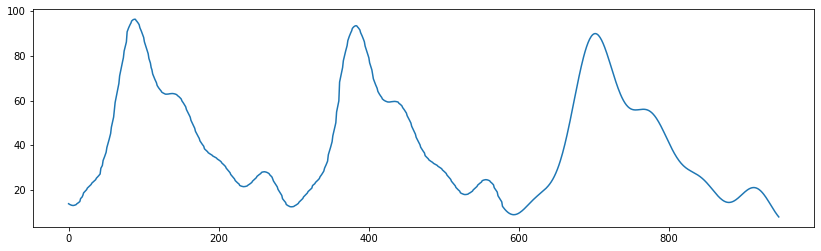

In [328]:
fcst.yhat.plot()

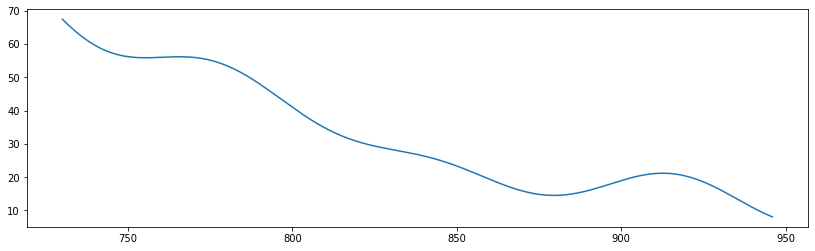

In [326]:
k = 2
fcst.yhat[k*365:(k+1)*365].plot()

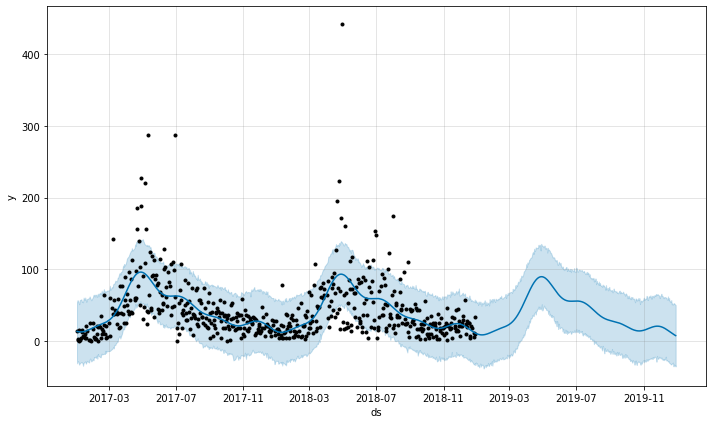

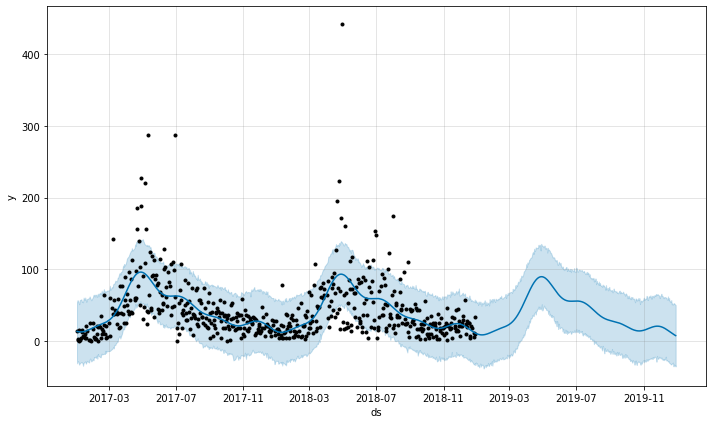

In [327]:
m.plot(fcst)

In [150]:
pred = inv_boxcox(pred, lmbda)

In [151]:
fcst = pd.Series(pred, index=test[item_id].index)

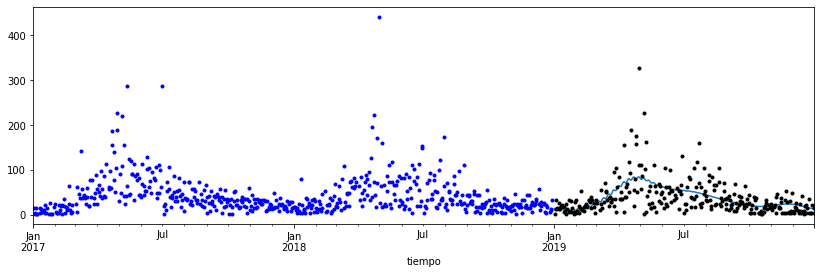

In [152]:
fcst.plot()
test[item_id].plot(style="k.")
train[item_id].plot(style="b.")

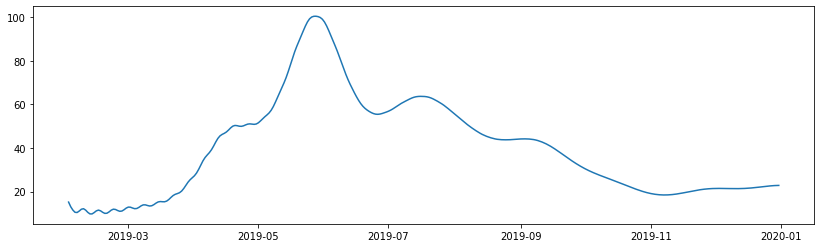

In [88]:
plt.plot(fcst)

In [43]:
len(test)

334

In [38]:
x = np.arange(0, 3*365)
K = 10
M = 365
coeff_sin = np.zeros((len(x), K))
coeff_cos = np.zeros((len(x), K))
for k in range(K):
    coeff_sin[:, k] = np.sin(2*np.pi*(k+1)*x/M)
    coeff_cos[:, k] = np.cos(2*np.pi*(k+1)*x/M)
np.concatenate((coeff_sin, coeff_cos), axis=1)

In [52]:
x = np.arange(0, 3*365)
K = 10
M = 365
coeff = np.zeros((len(x), K), dtype="complex")
for k in range(K):
    coeff[:, k] = np.exp(1j*2*np.pi*(k+1)*x/M)


In [48]:
np.concatenate((coeff_sin, coeff_cos), axis=1)

(1095, 20)

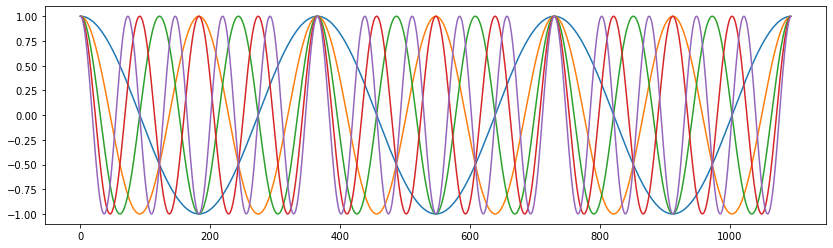

In [54]:
for k in range(5):
    plt.plot(x, coeff[:,k].real)

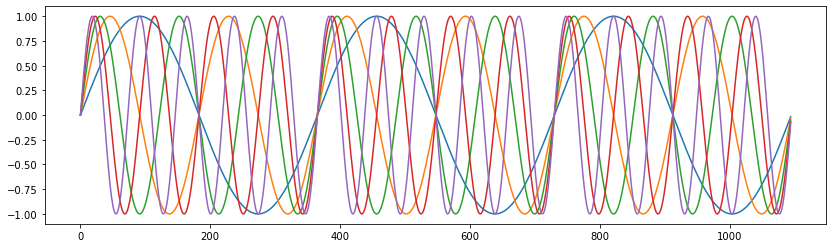

In [45]:
for k in range(5):
    plt.plot(x, coeff_sin[:,k])

In [36]:
x.shape

(1095,)

In [33]:
np.zeros((365*2, 10))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

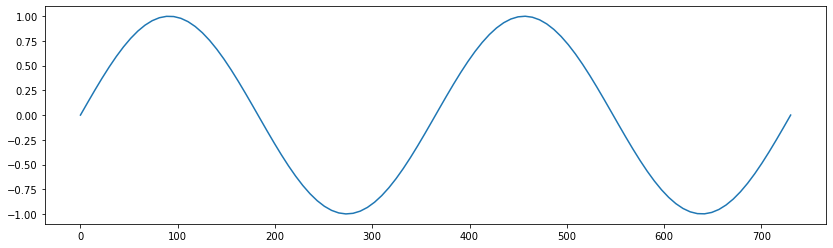

In [29]:
plt.plot(x, y)

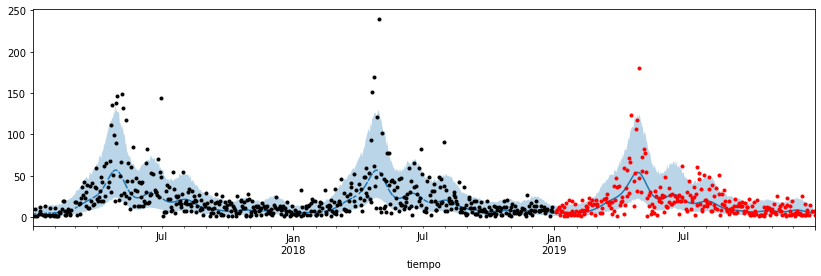

In [20]:
item = 44155
plot_fcst(fcst[item], train[item], test[item])

# Forecast por producto y región

In [21]:
u_producto_region = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns=["producto", "sucursal"], 
    aggfunc="sum").asfreq("D")

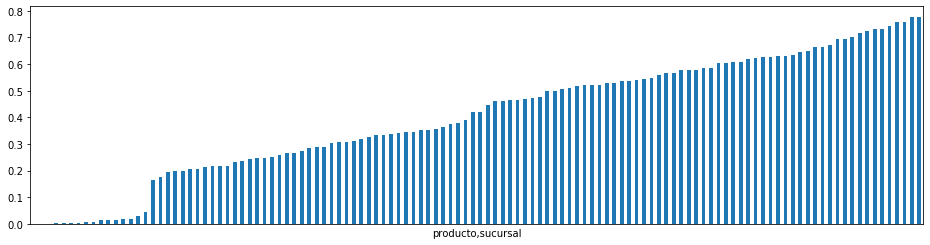

In [35]:
get_amount_info(u_producto_region).sort_values().plot(kind="bar", figsize=(16,4))
plt.xticks(ticks=[]);

In [24]:
u_producto_region_forecastable = get_forecastables(u_producto_region, T=0.3)

In [25]:
train, test = u_producto_region_forecastable[:"2018-12-31"], u_producto_region_forecastable["2019-01-01":]

In [26]:
model = ProphetForecaster(
    yearly_seasonality=10,
    weekly_seasonality=False, 
    daily_seasonality=False,)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


80 of 80|#################################################################|100%


Forecasting...


80 of 80|#################################################################|100%


In [27]:
fcst

16061                                                       \
              neuquen                        santa fe                        
           yhat_lower      yhat yhat_upper yhat_lower      yhat yhat_upper   
ds                                                                           
2017-01-02        NaN       NaN        NaN   1.621817  5.386577  15.683748   
2017-01-03        NaN       NaN        NaN   1.390607  5.406648  16.699142   
2017-01-04        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-05        NaN       NaN        NaN   1.436094  5.440789  16.682178   
2017-01-06        NaN       NaN        NaN        NaN       NaN        NaN   
...               ...       ...        ...        ...       ...        ...   
2019-12-25   1.382195  5.541953  16.047625   1.832049  6.397680  18.138644   
2019-12-26   1.020122  5.396920  14.849836   1.794442  6.348595  19.675285   
2019-12-27   1.019241  5.265696  14.964361   1.879872  6.314513  20.094280   
2019-12-28   1.000660  5.148950  14.903477   1.931588  6.294069  18.708877   
2019-12-29   1.107906  5.046966  14.344457   1.911706  6.285694  18.135725   

                16062                                  ...      90745  \
              neuquen                        santa fe  ...    neuquen   
           yhat_lower      yhat yhat_upper yhat_lower  ... yhat_upper   
ds                                                     ...              
2017-01-02        NaN       NaN        NaN   0.723761  ...        NaN   
2017-01-03        NaN       NaN        NaN        NaN  ...        NaN   
2017-01-04        NaN       NaN        NaN        NaN  ...        NaN   
2017-01-05        NaN       NaN        NaN        NaN  ...        NaN   
2017-01-06        NaN       NaN        NaN   0.761337  ...        NaN   
...               ...       ...        ...        ...  ...        ...   
2019-12-25   0.611027  1.860933   6.497507   0.689933  ...  15.139345   
2019-12-26   0.643769  1.958496   6.656144   0.759867  ...  14.110996   
2019-12-27   0.672071  2.068379   8.672655   0.762676  ...  13.449616   
2019-12-28   0.753807  2.190337   8.690868   0.754653  ...  13.513202   
2019-12-29   0.806587  2.323737  10.669851        NaN  ...  12.481264   

                                                90746                       \
             santa fe                         neuquen                        
           yhat_lower      yhat yhat_upper yhat_lower      yhat yhat_upper   
ds                                                                           
2017-01-02        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-03        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-04        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-05        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-06        NaN       NaN        NaN        NaN       NaN        NaN   
...               ...       ...        ...        ...       ...        ...   
2019-12-25   2.322525  5.172407  11.232223   0.660931  1.510417   4.264204   
2019-12-26   2.338193  5.172024  12.244235   0.655615  1.507262   4.518459   
2019-12-27   2.336391  5.152467  12.858118   0.663800  1.505460   4.824693   
2019-12-28   2.401454  5.115178  12.898156   0.670316  1.504914   4.445017   
2019-12-29   2.258034  5.062273  12.017469   0.650984  1.505549   4.428513   

                                            
             santa fe                       
           yhat_lower      yhat yhat_upper  
ds                                          
2017-01-02        NaN       NaN        NaN  
2017-01-03        NaN       NaN        NaN  
2017-01-04        NaN       NaN        NaN  
2017-01-05        NaN       NaN        NaN  
2017-01-06        NaN       NaN        NaN  
...               ...       ...        ...  
2019-12-25   0.781537  1.730692   4.737335  
2019-12-26   0.727671  1.757224   4.493655  
2019-12-27   0.723934  1.783074   4.66

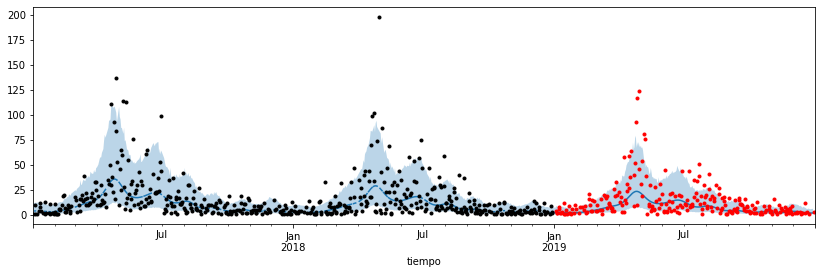

In [29]:
item = (44155, "santa fe")
plot_fcst(fcst[item], train[item], test[item])